In [1]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf
import os
import sys
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
#from itertools import chains
from scipy import stats
import scipy.optimize as opt
import random
from IPython.display import clear_output
from datetime import date
import pingouin as pg
from sklearn.linear_model import LinearRegression
import dill
from itertools import chain
clear_output()

In [9]:
# output a list of animals ready to pull
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

# Select animals to analyze
AIDList = [''.join(['CL-', f"{x:02}"]) for x in range(13, 30)] + [''.join(['LFP', f"{x:02}"]) for x in range(16, 22)]

# Name the output directory
output_directory_name =  'ChronicLesions_Contingency-reversal_Dec21'

# Create out directory if it does not exist
outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)
    
hue_order = ['Control', 'Lesion']
LSpalette = [(0.24715576, 0.49918708, 0.57655991), (160/255, 11/255 , 11/255)]
sns.set_palette(LSpalette)

In [10]:
# Read the dataframes and merge them
DataFrames = []
for AID in AIDList:
    DFfile = GeneralDirectory + AID + BpodProtocol + AID + '_dataframe.pkl'
    ADF = pd.read_pickle(DFfile)
    DataFrames.append(ADF)
AnimalsDF = pd.concat(DataFrames, ignore_index=True)

In [11]:
# get a list of each animalID in each condition
for EG in pd.unique(AnimalsDF.ExperimentalGroup):
    print(str(EG) + ':')
    for AI in pd.unique(AnimalsDF[AnimalsDF.ExperimentalGroup == EG].AnimalID):
        print('  ' + AI)

Lesion:
  CL-13
  CL-14
  CL-15
  CL-16
  CL-17
  CL-18
  CL-19
  CL-20
  CL-21
  CL-22
  CL-23
  CL-24
Control:
  CL-25
  CL-26
  CL-27
  CL-28
  CL-29
  LFP16
  LFP17
  LFP18
  LFP19
  LFP20
  LFP21


In [12]:
# Print output for report
print('Date of analysis:', date.today())
print('Output folder:', outputDir)

Date of analysis: 2022-01-10
Output folder: /home/hernandom/data/Behavioural_Data/Bpod_data/ChronicLesions_Contingency-reversal_Dec21_Analysis/


In [13]:
# Create a unique ID for every session
def mergeStrings(df):
    return df['AnimalID'] + ' ' + df['SessionTime']

AnimalsDF['SessionID'] = AnimalsDF[['AnimalID', 'SessionTime']].apply(mergeStrings, axis=1)

In [14]:
# Select only the auditory reversal of contingency
# Select only the auditory for now
protocols_selected = ['Auditory']
AnimalsDF = AnimalsDF[AnimalsDF.Protocol.isin(protocols_selected)]

# Remove initial contingency
cont_to_keep = [2]
AnimalsDF = AnimalsDF[AnimalsDF.Contingency.isin(cont_to_keep)]

In [15]:
# Remove trials in which the animals are disengaged
# Create also a column that holds the ITIs
ITIs_list = []
disengaged_global_indexes = []

for Sid in pd.unique(AnimalsDF['SessionID']):
    itis = cuf.itis_calculator(AnimalsDF[AnimalsDF['SessionID']==Sid])
    ITIs_list.append(itis)
    # Identify the trials where there is disengament
    dis_idx = cuf.find_disengaged_trials(itis)
    # print information of percentage removed
#     print('{0}, with {1} trials, {2:%} are removed'.format(Sid, len(itis), len(dis_idx)/len(itis)))
    # Find their global index
    dgi = list(AnimalsDF[AnimalsDF['SessionID']==Sid].index[dis_idx])
    # Add them to list
    disengaged_global_indexes = disengaged_global_indexes + dgi

# flatten the list of lists
AnimalsDF['ITIs'] = np.array(list(chain(*[x for x in ITIs_list])))

# remove these trials from the dataframe
AnimalsDF = AnimalsDF.drop(disengaged_global_indexes)

print('Removal of a total of {} trials where mice were disengaged'.format(len(disengaged_global_indexes)))

Removal of a total of 3206 trials where mice were disengaged


In [16]:
# Create a cumulative trial number for every animal BE AWARE THAT SESSIONS MIGHT HAVE BEEN REMOVED BEFORE SO THIS NUMBER IS NOT EXACT
CumTrialsList = []
for Aid in pd.unique(AnimalsDF['AnimalID']):
    CumTrialsList.append(np.arange(len(AnimalsDF[AnimalsDF['AnimalID']==Aid])) + 1)
# flatten the list of lists
AnimalsDF['CumulativeTrialNumber'] = np.array(list(chain(*[x for x in CumTrialsList])))

In [17]:
# maximum number of trials performed per mouse in the dataset:
AnimalsDF.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).max()['CumulativeTrialNumber']

AnimalID  ExperimentalGroup  Protocol
CL-14     Lesion             Auditory    2528
CL-15     Lesion             Auditory    6404
CL-16     Lesion             Auditory    3384
CL-17     Lesion             Auditory    5973
CL-18     Lesion             Auditory    4226
CL-19     Lesion             Auditory    1644
CL-23     Lesion             Auditory    5334
CL-24     Lesion             Auditory    3886
CL-25     Control            Auditory    7185
CL-26     Control            Auditory    3857
CL-27     Control            Auditory    3504
CL-28     Control            Auditory    1012
CL-29     Control            Auditory    3253
Name: CumulativeTrialNumber, dtype: int64

In [18]:
# Calculate performance of the past X trials
PAST_WINDOW = 100
CumPerList = []
for Sid in pd.unique(AnimalsDF['SessionID']):
    CumPerList.append(cuf.perf_window_calculator(AnimalsDF[AnimalsDF['SessionID']==Sid], PAST_WINDOW))
# flatten the list of lists
AnimalsDF['CurrentPastPerformance100'] = np.array(list(chain(*[x for x in CumPerList])))

In [19]:
# bin trials every 200
AnimalsDF["TrialIndexBinned200"] = (AnimalsDF.CumulativeTrialNumber // 200) * 200 + 100

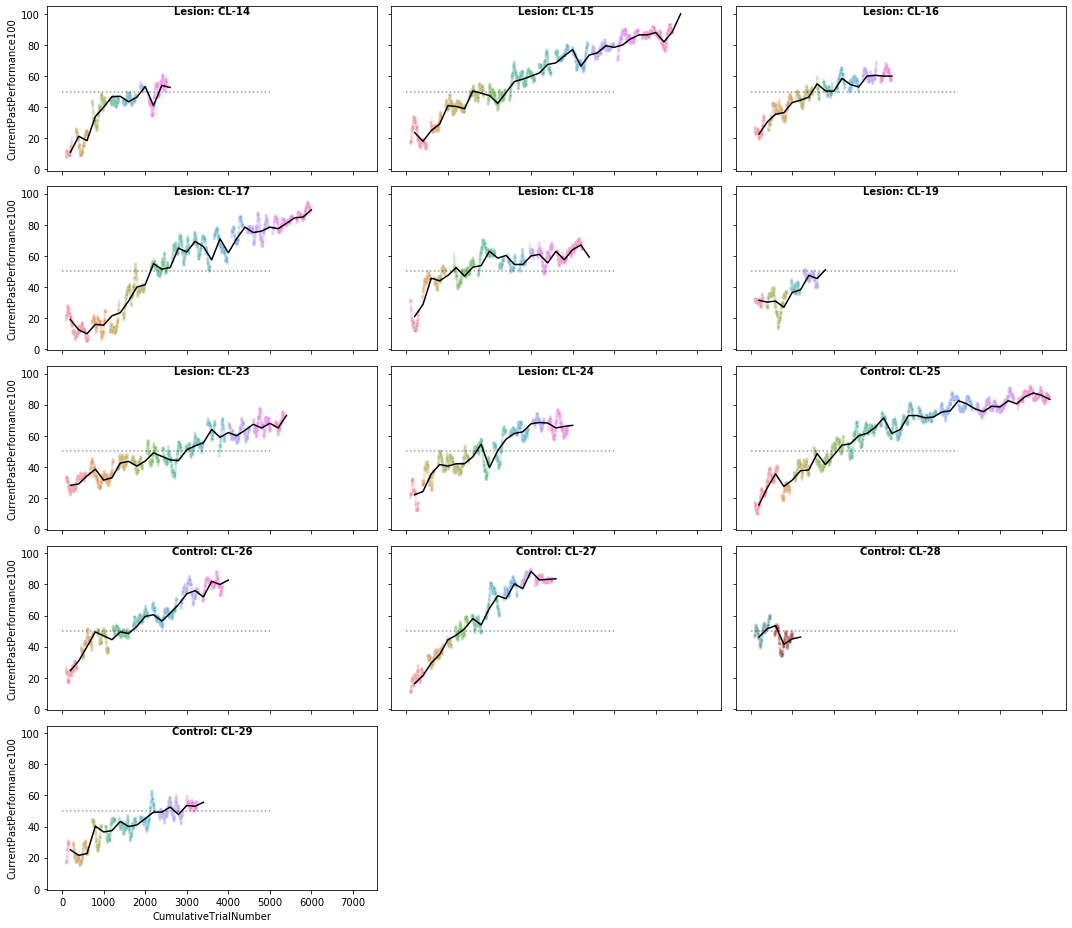

In [20]:
# Sanity check on the data to see that it looks good
ans_list = np.sort(AnimalsDF.AnimalID.unique())
num_ans = len(ans_list)
fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    
    # plot here
    sns.scatterplot(data=AnimalsDF[AnimalsDF.AnimalID == animal],
                x="CumulativeTrialNumber",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    # plot a line for binned trials
    sns.lineplot(x=AnimalsDF[AnimalsDF.AnimalID == animal]["TrialIndexBinned200"] + 100, #trick to align as
                 #CurrentPastPerformance looks at the past 
                 y=100 * AnimalsDF[AnimalsDF.AnimalID == animal]["FirstPokeCorrect"],
                 color='k',
                 ci=None,
                 ax=ax)
    
    
    ax.get_legend().remove()
    ec = AnimalsDF[AnimalsDF.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
update_progress(1)
plt.savefig(outputDir + 'Performance_by_session_individual_animals_reverse-contingency.pdf', transparent=True, bbox_inches='tight')
clear_output()
plt.show(fig)

In [21]:
# Select animals to remove from the study based on this
ans_to_remove = ['CL-28', 'CL-13']
# ans_to_remove = []
df_sel = AnimalsDF[~AnimalsDF.AnimalID.isin(ans_to_remove)].copy()
print('Animals removed from the following analysis based on this:', ans_to_remove)

Animals removed from the following analysis based on this: ['CL-28', 'CL-13']


Shaded area indicates std, and performance is calculated using CurrentPastPerformance100


/home/hernandom/.conda/envs/behav/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


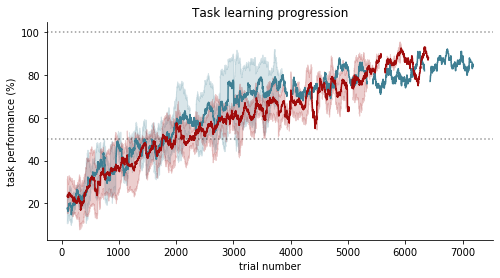

In [22]:
# create a publication-quality figure, grouping the data by the Experimental Group, and showing the continous monitoring
# of learning
col_to_plot = 'CurrentPastPerformance100'
data_mean = df_sel.groupby(['CumulativeTrialNumber','ExperimentalGroup'])[col_to_plot].mean().reset_index()
st_err_mean = df_sel.groupby(['CumulativeTrialNumber','ExperimentalGroup'])[col_to_plot].std().reset_index()
data_mean['low_bound'] = data_mean[col_to_plot] - st_err_mean[col_to_plot]
data_mean['high_bound'] = data_mean[col_to_plot] + st_err_mean[col_to_plot]

fig1 = plt.figure(figsize=(8, 4))
plt.axhline(50, ls='dotted', alpha=0.4, color='k')
plt.axhline(100, ls='dotted', alpha=0.4, color='k')
for i,eg in enumerate(hue_order):
    df = data_mean[data_mean.ExperimentalGroup==eg].copy()
    x = df.CumulativeTrialNumber
    plt.plot(x, df[col_to_plot], color=LSpalette[i], label=eg)
    #plt.plot(data_mean[data_mean.ExperimentalGroup==eg][col_to_plot], linestyle='--', color=LSpalette[i], label='95% ci')
    #plt.plot(neg_ci, linestyle='--', color='k')
    y1 = df['low_bound']
    y2 = df['high_bound']
    plt.fill_between(x, y1, y2, where=y2 >= y1, color=LSpalette[i], alpha=.2, interpolate=False)

plt.ylabel(col_to_plot)
plt.xlabel('trial number')
plt.ylabel('task performance (%)')
plt.legend(loc=(0.76,0.3), frameon=False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# remove the legend as the figure has it's own
ax.get_legend().remove()

# ax.set_xlim((0,5000))

plt.title('Task learning progression')

plt.savefig(outputDir + 'Performance_between_groups_contingency-reversal.pdf', transparent=True, bbox_inches='tight')
fig1.show()
print('Shaded area indicates std, and performance is calculated using', col_to_plot)